In [ ]:
import numpy as np
import csv
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
def sslMarkovRandomWalks(xl, yl, xu, gamma, improvement):
    x = np.vstack((xl, xu))
    n = len(yl)
    m = xu.shape[0]
    L = x.shape[0]
    ypred=np.zeros(m)
    At = np.zeros((L, L))
    rsum = 0
    ksum=0
    
    #Defining the transition matrix based on gaussian kernel
    for i in range(L):
        if i < n:
            At[i][i] = 1
        else:
            for j in range(L):
                At[i][j] = np.exp(-(np.sum((x[i, :] - x[j, :]) ** 2)) / gamma)
                rsum = rsum + At[i][j]
            At[i, :] = At[i, :] / rsum
            rsum = 0
   
    #Defining and updating the probability vector while performing the random walk
    P = (np.zeros(L))*(1/L)
    Pold=np.zeros(L)
    for i in range(n,L):
        k=0
        P[i]=1
        while ((P - Pold) ** 2).sum() > improvement:
            Pold = P.copy()
            P = P.dot(At)
            k+=1
        ypred[i-n]=yl.iloc[int(np.argmax(P[:n]))]
        P=np.zeros(L)
        ksum+=k
    print("Average Iteration: %f" %(ksum/m))  

    return ypred

In [ ]:
#REQUIREMENT: The uploaded csv should have labels in the last column.If this is not the case please modify the csv to have labels in the last column.

df=pd.read_csv("iby.csv")
df

,Unnamed: 0,ratio,speech_speed,nega_posi,angry_mean_s,fear_mean_s,happy_mean_s,sad_mean_s,neutral_mean_s,angry_std_s,...,grade_en_others,grade_en_primary_school,grade_en_university,goal_en_not_entrance_exam,teacher_rank_en_mid-level_pro_teacher,teacher_rank_en_pro_teacher,teacher_rank_en_student_teacher,teacher_rank_en_top-level_pro_teacher,teacher_rank_en_young_pro_teacher,0
0,0,87.590310,116.985782,0.720379,5.855582,14.997000,6.814656,22.761731,47.729376,5.778425,...,0,0,0,0,0,0,0,0,1,0
1,1,91.995490,201.232558,0.988372,10.466422,13.607339,11.898716,10.341651,49.682202,8.053332,...,0,0,0,1,0,0,0,0,0,0
2,2,86.680328,113.419355,0.112903,21.305781,11.982252,0.297160,8.061359,47.522819,12.978979,...,0,0,0,1,0,0,1,0,0,0
3,3,64.840326,205.399061,1.056338,4.833333,45.583333,7.000000,30.250000,2.833333,0.834847,...,0,0,0,0,0,0,0,1,0,0
4,4,57.543103,129.078652,0.511236,6.791793,18.518237,14.009119,11.737842,45.508359,9.162037,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,1798,75.155963,120.888889,0.601852,8.538021,8.541528,20.464563,7.036545,51.033776,9.768397,...,0,0,0,1,1,0,0,0,0,0
1799,1799,66.770186,86.302439,0.214634,19.280336,23.323188,3.009612,14.301962,36.816980,12.419868,...,0,0,0,1,1,0,0,0,0,0
1800,1800,66.159292,120.265060,0.524096,28.831865,11.449159,1.692954,19.373098,36.748599,15.412852,...,0,0,0,1,1,0,0,0,0,0
1801,1801,80.685849,237.689655,0.442529,14.146327,16.260960,1.207642,10.524882,39.445794,13.264530,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803 entries, 0 to 1802
Data columns (total 46 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             1803 non-null   int64  
 1   ratio                                  1803 non-null   float64
 2   speech_speed                           1803 non-null   float64
 3   nega_posi                              1803 non-null   float64
 4   angry_mean_s                           1803 non-null   float64
 5   fear_mean_s                            1803 non-null   float64
 6   happy_mean_s                           1803 non-null   float64
 7   sad_mean_s                             1803 non-null   float64
 8   neutral_mean_s                         1803 non-null   float64
 9   angry_std_s                            1803 non-null   float64
 10  fear_std_s                             1803 non-null   float64
 11  happ

In [ ]:
df.describe()


,Unnamed: 0,ratio,speech_speed,nega_posi,angry_mean_s,fear_mean_s,happy_mean_s,sad_mean_s,neutral_mean_s,angry_std_s,...,grade_en_others,grade_en_primary_school,grade_en_university,goal_en_not_entrance_exam,teacher_rank_en_mid-level_pro_teacher,teacher_rank_en_pro_teacher,teacher_rank_en_student_teacher,teacher_rank_en_top-level_pro_teacher,teacher_rank_en_young_pro_teacher,0
count,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,...,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.00000,1803.000000,1803.000000,1803.000000
mean,901.000000,72.485567,119.195439,0.453938,13.752422,13.736639,15.723681,14.599348,38.648445,9.999899,...,0.008874,0.016084,0.001109,0.612313,0.156406,0.002219,0.30782,0.143095,0.177482,0.057682
std,520.625585,15.209721,48.346928,0.298360,9.630261,8.252767,13.359349,7.422729,14.761384,5.038444,...,0.093810,0.125835,0.033296,0.487358,0.363341,0.047062,0.46172,0.350267,0.382182,0.233205
min,0.000000,0.043956,0.000000,-0.461111,0.000000,0.132353,0.044226,0.169118,1.001195,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,450.500000,64.029370,86.055599,0.248677,6.739522,8.161945,5.479250,9.307809,28.208308,6.160747,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,901.000000,73.818052,118.256684,0.421053,11.213920,11.735663,11.852182,13.330581,38.555556,9.203169,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,1351.500000,82.658537,149.798125,0.637101,18.363694,17.145519,22.229250,18.473133,48.868721,13.276653,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000
max,1802.000000,100.000000,318.581818,2.120482,62.933898,62.845361,97.683824,48.827586,85.988262,27.750639,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


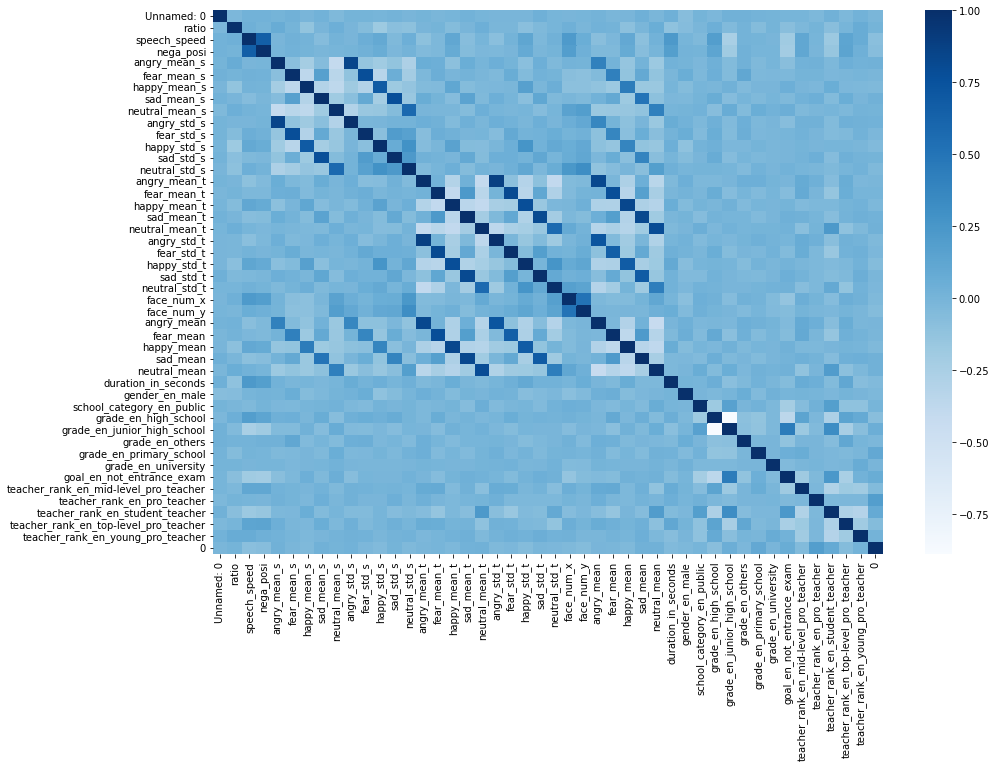

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),cmap='Blues',annot=False) 

In [ ]:
#Run this cell if highly correlated features need to be removed


corr_matrix=cor.abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
threshold=0.8

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_drop
df=df.drop(df[to_drop], axis=1)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


,Unnamed: 0,ratio,speech_speed,nega_posi,angry_mean_s,fear_mean_s,happy_mean_s,sad_mean_s,neutral_mean_s,fear_std_s,...,grade_en_others,grade_en_primary_school,grade_en_university,goal_en_not_entrance_exam,teacher_rank_en_mid-level_pro_teacher,teacher_rank_en_pro_teacher,teacher_rank_en_student_teacher,teacher_rank_en_top-level_pro_teacher,teacher_rank_en_young_pro_teacher,0
0,0,87.590310,116.985782,0.720379,5.855582,14.997000,6.814656,22.761731,47.729376,10.157461,...,0,0,0,0,0,0,0,0,1,0
1,1,91.995490,201.232558,0.988372,10.466422,13.607339,11.898716,10.341651,49.682202,8.911456,...,0,0,0,1,0,0,0,0,0,0
2,2,86.680328,113.419355,0.112903,21.305781,11.982252,0.297160,8.061359,47.522819,7.751741,...,0,0,0,1,0,0,1,0,0,0
3,3,64.840326,205.399061,1.056338,4.833333,45.583333,7.000000,30.250000,2.833333,6.907944,...,0,0,0,0,0,0,0,1,0,0
4,4,57.543103,129.078652,0.511236,6.791793,18.518237,14.009119,11.737842,45.508359,17.623493,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,1798,75.155963,120.888889,0.601852,8.538021,8.541528,20.464563,7.036545,51.033776,10.572247,...,0,0,0,1,1,0,0,0,0,0
1799,1799,66.770186,86.302439,0.214634,19.280336,23.323188,3.009612,14.301962,36.816980,13.166041,...,0,0,0,1,1,0,0,0,0,0
1800,1800,66.159292,120.265060,0.524096,28.831865,11.449159,1.692954,19.373098,36.748599,7.533772,...,0,0,0,1,1,0,0,0,0,0
1801,1801,80.685849,237.689655,0.442529,14.146327,16.260960,1.207642,10.524882,39.445794,10.953654,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df.iloc[:,-1] = label_encoder.fit_transform(df.iloc[:,-1])

#Feature Scaling
cols=list(df.columns)
scaler = preprocessing.MinMaxScaler()
df_scaled = scaler.fit_transform(df.loc[:,cols[:-1]].to_numpy())
df_scaled = pd.DataFrame(df_scaled,columns=cols[:-1])
df=pd.concat([df_scaled,df.loc[:,cols[-1]]],axis=1)

df


,Unnamed: 0,ratio,speech_speed,nega_posi,angry_mean_s,fear_mean_s,happy_mean_s,sad_mean_s,neutral_mean_s,fear_std_s,...,grade_en_others,grade_en_primary_school,grade_en_university,goal_en_not_entrance_exam,teacher_rank_en_mid-level_pro_teacher,teacher_rank_en_pro_teacher,teacher_rank_en_student_teacher,teacher_rank_en_top-level_pro_teacher,teacher_rank_en_young_pro_teacher,0
0,0.000000,0.875849,0.367208,0.457659,0.093043,0.237027,0.069341,0.464310,0.549827,0.319856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.000555,0.919920,0.631651,0.561469,0.166308,0.214867,0.121411,0.209060,0.572805,0.280620,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,0.001110,0.866745,0.356013,0.222349,0.338542,0.188954,0.002590,0.162197,0.547397,0.244101,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
3,0.001665,0.648249,0.644729,0.587796,0.076800,0.724746,0.071239,0.618204,0.021558,0.217530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.002220,0.575244,0.405166,0.376646,0.107919,0.293175,0.143025,0.237754,0.523693,0.554960,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,0.997780,0.751450,0.379459,0.411747,0.135666,0.134090,0.209140,0.141135,0.588708,0.332918,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0
1799,0.998335,0.667556,0.270896,0.261755,0.306359,0.369793,0.030371,0.290450,0.421426,0.414596,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0
1800,0.998890,0.661444,0.377501,0.381628,0.458129,0.180454,0.016886,0.394669,0.420622,0.237237,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0
1801,0.999445,0.806774,0.746087,0.350032,0.224781,0.257181,0.011915,0.212826,0.452358,0.344928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


0    1699
1     104
Name: 0, dtype: int64


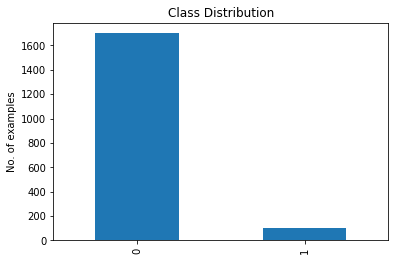

In [ ]:
class_counts=df.iloc[:,-1].value_counts()
print(class_counts)
plt.figure()
df.iloc[:,-1].value_counts().plot(kind="bar")
plt.ylabel("No. of examples")
plt.title("Class Distribution")
plt.savefig("Class Distribution.png")


In [ ]:
#Train-test split
L=df.shape[0]
cols=list(df.columns)
(Xtrain,Xtest,Ytrain,Ytest) = train_test_split(df.loc[:, cols[:-1]], df.loc[:, cols[-1]], train_size = 0.8, random_state = 42, stratify=df.loc[:, cols[-1]], shuffle=True)

#(Xtrain,Xtest,Ytrain,Ytest) = train_test_split(df_ovsam_X,df_ovsam_Y,train_size = 0.2, random_state = 42, stratify=df_ovsam_Y, shuffle=True)
Xtrain.shape[0]

1442

In [ ]:
#Run this cell if oversampling is required

oversample=SMOTE()
#undersample=RandomUnderSampler()
#steps = [('o', oversample), ('u', undersample)]
#pipeline = Pipeline(steps=steps)
Xtrain,Ytrain=oversample.fit_resample(Xtrain,Ytrain)
Xtrain

,Unnamed: 0,ratio,speech_speed,nega_posi,angry_mean_s,fear_mean_s,happy_mean_s,sad_mean_s,neutral_mean_s,fear_std_s,...,grade_en_high_school,grade_en_others,grade_en_primary_school,grade_en_university,goal_en_not_entrance_exam,teacher_rank_en_mid-level_pro_teacher,teacher_rank_en_pro_teacher,teacher_rank_en_student_teacher,teacher_rank_en_top-level_pro_teacher,teacher_rank_en_young_pro_teacher
0,0.028302,0.738115,0.534339,0.438272,0.127043,0.177151,0.199200,0.279829,0.456429,0.276069,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000
1,0.851831,0.779661,0.421820,0.386519,0.319035,0.175410,0.057397,0.206374,0.404367,0.265746,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.00000,1.0,0.0,0.00000
2,0.596559,0.789516,0.526709,0.148487,0.278659,0.245319,0.105844,0.445031,0.365290,0.335545,...,1.000000,0.0,0.0,0.0,1.0,1.0,0.00000,0.0,0.0,0.00000
3,0.897336,0.755593,0.361408,0.304881,0.071345,0.368510,0.089599,0.819212,0.249812,0.431087,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.00000,0.0,0.0,0.00000
4,0.253607,0.634646,0.401207,0.384468,0.096306,0.080883,0.262852,0.337630,0.529866,0.219513,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.00000,1.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713,0.038540,0.737567,0.439923,0.406938,0.206849,0.129572,0.113637,0.164408,0.647635,0.241204,...,1.000000,0.0,0.0,0.0,1.0,0.0,0.00000,0.0,0.0,0.00000
2714,0.195994,0.690305,0.095793,0.204581,0.256108,0.229961,0.051515,0.540118,0.414696,0.295037,...,1.000000,0.0,0.0,0.0,1.0,0.0,0.40688,0.0,0.0,0.59312
2715,0.537923,0.795193,0.299233,0.297011,0.449815,0.320094,0.023657,0.367240,0.323685,0.431120,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.00000,0.0,0.0,0.37987
2716,0.972716,0.672696,0.479558,0.423780,0.150617,0.106268,0.351312,0.209035,0.419444,0.272735,...,0.375951,0.0,0.0,0.0,1.0,0.0,0.00000,1.0,0.0,0.00000


Text(0.5, 1.0, 'Class Distribution')

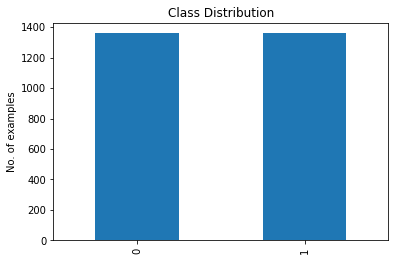

In [ ]:
class_counts=Ytrain.value_counts()
plt.figure()
Ytrain.value_counts().plot(kind="bar")
plt.ylabel("No. of examples")
plt.title("Class Distribution")

In [ ]:
def optimized_bandwidth(Xtrain,Ytrain,Xtest,Ytest):
    #Bandwidth Tuning
    r=np.linspace(0.005,0.1,num=15)
    e=[0.001*i for i in range(1,10)]
    p=[0.01*i for i in range(1,10)]
    s=[0.1*i for i in range(1,11)]
    r=e+p+s
    acc=np.zeros(len(r))
    class_acc=np.zeros(len(r))
    for i in range(len(r)):
        ypred=sslMarkovRandomWalks(Xtrain,Ytrain,Xtest,r[i],10**-5)
        cmat=confusion_matrix(Ytest,ypred)
        acc[i]=(ypred==Ytest).mean()
        print("Bandwidth: "+str(r[i])+" Accuracy: "+str(acc[i]))
    opt_b=r[np.argmax(acc)]
    return opt_b

def runtime_adjusted_improvement(Xtrain,Ytrain,Xtest,Ytest,margin):
    i=5;
    impr=10**-i
    while(i>0):
        ypred=sslMarkovRandomWalks(Xtrain,Ytrain,Xtest,0.01,10**-i)
        acc=(ypred==Ytest).mean()
        if (abs(acc-acc_old)>margin):
            break
        acc_old=acc
        i=-1
    
    return (10**-i)    

In [ ]:
%%time
#Specifying the hyperparameters

b=optimized_bandwidth(Xtrain,Ytrain,Xtest,Ytest)     #opt_b for raisin=0.02 b=0.6
improvement=(10**-5)
#b=0.01



Average It: 1.000000
Bandwidth: 0.001 Accuracy: 0.8587257617728532
Average It: 1.000000
Bandwidth: 0.002 Accuracy: 0.850415512465374
Average It: 1.000000
Bandwidth: 0.003 Accuracy: 0.853185595567867
Average It: 1.000000
Bandwidth: 0.004 Accuracy: 0.853185595567867
Average It: 1.000000
Bandwidth: 0.005 Accuracy: 0.853185595567867
Average It: 1.000000
Bandwidth: 0.006 Accuracy: 0.853185595567867
Average It: 1.000000
Bandwidth: 0.007 Accuracy: 0.853185595567867
Average It: 1.000000
Bandwidth: 0.008 Accuracy: 0.853185595567867
Average It: 1.000000
Bandwidth: 0.009000000000000001 Accuracy: 0.853185595567867
Average It: 1.000000
Bandwidth: 0.01 Accuracy: 0.853185595567867
Average It: 1.000000
Bandwidth: 0.02 Accuracy: 0.853185595567867
Average It: 2.792244
Bandwidth: 0.03 Accuracy: 0.853185595567867
Average It: 9.983380
Bandwidth: 0.04 Accuracy: 0.853185595567867
Average It: 21.030471
Bandwidth: 0.05 Accuracy: 0.853185595567867
Average It: 33.252078
Bandwidth: 0.06 Accuracy: 0.85318559556786

In [ ]:
b=0.01   #0.001

Average It: 1.000000
Accuracy: 0.853186
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       340
           1       0.14      0.29      0.18        21

    accuracy                           0.85       361
   macro avg       0.54      0.59      0.55       361
weighted avg       0.91      0.85      0.88       361



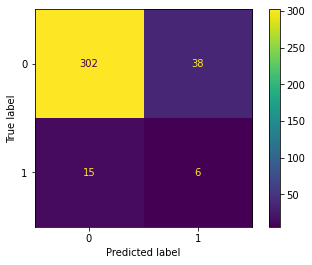

In [ ]:
ypred=sslMarkovRandomWalks(Xtrain,Ytrain,Xtest,b,improvement)        #84.4228%
print("Accuracy: %f"  %(ypred==Ytest).mean())
cmat=confusion_matrix(Ytest,ypred)
print(classification_report(Ytest,ypred))
ConfusionMatrixDisplay.from_predictions(Ytest, ypred)
      

In [ ]:
# Run these cells for comparative analysis  

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve


# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [ ]:
def Svm(Xtrain,Ytrain,Xtest,Ytest):
    svm = SVC(kernel='linear', C=6, random_state=42).fit(Xtrain,Ytrain)
    # predicting the values
    SVM_pred = svm.predict(Xtest)
    return accuracy_score(Ytest, SVM_pred)

In [ ]:
def rf(Xtrain,Ytrain,Xtest,Ytest):
    rf = RandomForestClassifier(n_estimators = 100)
    rf.fit(Xtrain, np.ravel(Ytrain))
    rfpred = rf.predict((Xtest))
    return accuracy_score(Ytest, rfpred)

In [ ]:
def knn(Xtrain,Ytrain,Xtest,Ytest):
    knn = KNeighborsClassifier(n_neighbors=4,p=2,n_jobs=-1)
    knn.fit(Xtrain,Ytrain)
    knnpred = knn.predict(Xtest)
    return accuracy_score(Ytest, knnpred)

In [ ]:
def logr(Xtrain,Ytrain,Xtest,Ytest):
    logr = LogisticRegression(C=1,max_iter=250,multi_class='auto')
    logr.fit(Xtrain,Ytrain)
    logpred = logr.predict(Xtest)
    return accuracy_score(Ytest, logpred)

In [ ]:
def gbc(Xtrain,Ytrain,Xtest,Ytest):
    GBC = GradientBoostingClassifier(n_estimators=300, learning_rate=10**-2,max_depth=20)
    GBC.fit(Xtrain,Ytrain)
    GBCpred = GBC.predict(Xtest)
    return accuracy_score(Ytest, GBCpred)

In [ ]:
q=np.linspace(10,3*(L//4),num=10)
acc_mrw=np.zeros(len(q))
acc_rf=np.zeros(len(q))
acc_log=np.zeros(len(q))
acc_GBC=np.zeros(len(q))
acc_knn=np.zeros(len(q))
acc_svm=np.zeros(len(q))
for i in range(len(q)):
    n=int(q[i])
    Xtrain,Xtest,Ytrain,Ytest = train_test_split(df.loc[:, cols[:-1]], df.loc[:, cols[-1]], train_size = n, random_state = 42, stratify=df.loc[:, cols[-1]], shuffle=True)
    ypred=sslMarkovRandomWalks(Xtrain,Ytrain,Xtest,b,10**-5)
    acc_mrw[i]=(ypred==Ytest).mean()
    acc_rf[i]=rf(Xtrain,Ytrain,Xtest,Ytest)
    acc_log[i]=logr(Xtrain,Ytrain,Xtest,Ytest)
    acc_knn[i]=knn(Xtrain,Ytrain,Xtest,Ytest)
    acc_svm[i]=Svm(Xtrain,Ytrain,Xtest,Ytest)
    acc_GBC[i]=gbc(Xtrain,Ytrain,Xtest,Ytest)



Average It: 1.000000
Average It: 1.000000
Average It: 1.000000
Average It: 1.000000
Average It: 1.000000
Average It: 1.000000
Average It: 1.000000
Average It: 1.000000
Average It: 1.000000
Average It: 1.000000


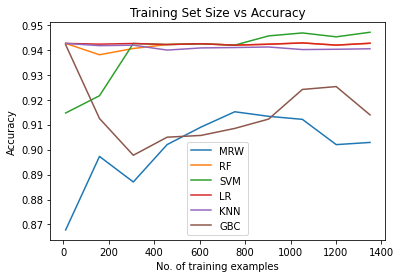

In [ ]:
plt.plot(q,acc_mrw,label="MRW")
plt.plot(q,acc_rf,label="RF")
plt.plot(q,acc_svm,label="SVM")
plt.plot(q,acc_log,label="LR")
plt.plot(q,acc_knn,label="KNN")
plt.plot(q,acc_GBC,label="GBC")
plt.title("Training Set Size vs Accuracy")
plt.xlabel("No. of training examples")
plt.ylabel("Accuracy")
plt.legend()